# Goal of this Project

The goal of this project is to cluster scientifical papers based on theirs abstract with unsupervised ML methods.

By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of papers can be represented as a scatter plot. On this plot, papers of highly similar topics will share a label and will be plotted near each other. As a bonus (if clustering works well) I try to find meaning in the clusters by using topic modelling to find the keywords of each cluster.
This can help to find publications with similar research backgrounds and to compare similar research and publications.

The data must be prepared accordingly so that they can be processed with a clustering model.
I use NLP (Natural Language Processing) to prepare the data. With this notebook I also want to test how certain preprocessing steps affect the quality of the clusters (stops word removing, handling different languages, different vectorization strategies).

This project will be done with the [arXiv Dataset](https://www.kaggle.com/Cornell-University/arxiv) featured on kaggle.com

# Approach:

- Load data
- Parse the text from the abstract of each document using Natural Language Processing (NLP).
- Turn each abstract into a feature vector using Term Frequency–inverse Document Frequency (TF-IDF).
- Use Principal Component Analysis (PCA) for dimensionality reduction
- Apply Dimensionality Reduction to each feature vector using t-Distributed Stochastic Neighbor Embedding (t-SNE) and umap.
- Apply k-means clustering
- Visualize clusters as a (interactive) scatterplot
- **Bonus:** Apply Topic Modeling for each cluster

Content:
1. Load data
2. Short EDA and some basic data-cleaning / feature engineering
3. NLP data preprocessing
4. Vectorization of the abstracts and dimensionality reduction with PCA
5. Clustering
6. t-SNE and umap (Using umap to see difference to t-SNE)
7. Compare t-SNE and umap
8. Plots an interactive scatter plot

### About the ArXiv dataset:
> For nearly 30 years, ArXiv has served the public and research communities by providing open access to scholarly articles, from the vast branches of physics to the many subdisciplines of computer science to everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. This rich corpus of information offers significant, but sometimes overwhelming depth.
In these times of unique global challenges, efficient extraction of insights from data is essential. To help make the arXiv more accessible, we present a free, open pipeline on Kaggle to the machine-readable arXiv dataset: a repository of 1.7 million articles, with relevant features such as article titles, authors, categories, abstracts, full text PDFs, and more.
Our hope is to empower new use cases that can lead to the exploration of richer machine learning techniques that combine multi-modal features towards applications like trend analysis, paper recommender engines, category prediction, co-citation networks, knowledge graph construction and semantic search interfaces.

>#### Cite: https://www.kaggle.com/Cornell-University/arxiv

# Load the data
If the whole dataset is to be loaded, it is recommended in the footnote of the dataset to load the dataset with the library [dask](http://dask.org).
Dask makes it possible to load lager datasets an process large amount of data on personal computers or VM's with limited resources

About dask:

> Dask is a flexible library for parallel computing in Python.

> From dask.org

In [3]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json
import pandas as pd

docs = db.read_text('./arxiv-metadata-oai-snapshot.json').map(json.loads)

In [4]:
#Total number of documents: 1872765
docs.count().compute()

2426574

In [5]:
# Looking at one document:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [6]:
# The dataset is very huge. Not sure if the whole set can be used. I start prototyping with a subset of the data so it's easyer to handel:
# This procedure was recommended in the ArXiv dataset itself

get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [7]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [8]:
#Let's have a look at the first 5 rows:
docs_df.head()

id                                            authors  \
0  0704.0033  Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. ...   
1  0704.0038                Maxim A. Yurkin, Alfons G. Hoekstra   
2  0704.0479                                          T.Geisser   
3  0704.1445            Yasha Gindikin and Vladimir A. Sablikov   
4  0704.1476                                       Chris Austin   

                                               title  \
0  Convergence of the discrete dipole approximati...   
1  The discrete dipole approximation: an overview...   
2               The affine part of the Picard scheme   
3  Deformed Wigner crystal in a one-dimensional q...   
4  TeV-scale gravity in Horava-Witten theory on a...   

                                                 doi  \
0    10.1364/JOSAA.23.002578 10.1364/JOSAA.32.002407   
1  10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...   
2                                               None   
3                         10.1103/PhysRevB.76.045122   
4                                               None   

                               category  \
0     [physics.optics, physics.comp-ph]   
1     [physics.optics, physics.comp-ph]   
2                    [math.AG, math.KT]   
3  [cond-mat.str-el, cond-mat.mes-hall]   
4                              [hep-th]   

                                            abstract  
0    We performed a rigorous theoretical converge...  
1    We present a review of the discrete dipole a...  
2    We describe the maximal torus and maximal un...  
3    The spatial Fourier spectrum of the electron...  
4    The field equations and boundary conditions ...

# Short EDA and some basic data-cleaning / feature engineering

In [9]:
df = pd.read_csv("./trimmed_arxiv_docs.csv")

/var/folders/hn/p77x1w5x5s725x1wyvhfn59h0000gn/T/ipykernel_7112/223106121.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./trimmed_arxiv_docs.csv")


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992613 entries, 0 to 992612
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        992613 non-null  object
 1   authors   992613 non-null  object
 2   title     992613 non-null  object
 3   doi       341265 non-null  object
 4   category  992613 non-null  object
 5   abstract  992613 non-null  object
dtypes: object(6)
memory usage: 45.4+ MB


In [11]:
df.shape

(992613, 6)

In [12]:
#Addint word counts of each abstract could be a usefull feature
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split()))

In [13]:
df['abstract'].describe(include='all')

count                                                992613
unique                                               992424
top         arXiv admin note: This submission has been w...
freq                                                      3
Name: abstract, dtype: object

In [14]:
#There are duplicated abstracts, would be the best to get rid of these
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                992424
unique                                               992424
top         We performed a rigorous theoretical converge...
freq                                                      1
Name: abstract, dtype: object

The raw text of the abstracts can't be processed by a model. Next step now is to transform the data in two steps:

- Use NLP to restructur the abstract text --> Remove Stop words an punctuation
- Vectorize the abstact's of each paper

The NLP wasn't cover in the course. Most of the strategies use in the next steps are based on the kaggle NLP Course https://www.kaggle.com/learn/natural-language-processing

# NLP data preprocessing

In [15]:
# the dataframe contains still hugh amount of data. The process the data faster I reduce the df to 10000 rows
# The scope of the notebook is not to analyze all data
df = df.sample(10000, random_state=42)

In [16]:
from tqdm import tqdm
# I discoverd that it's possible to download models for the specific purpose to preprocess scientific texts
# In the spacy docs I found a specific model for this : https://spacy.io/universe/project/scispacy
#Downloading en_core_sci_lg model to preprocess abstracts
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [17]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [18]:
#Import NLP librarys and the spacy package to preprocess the abstract text
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #import commen list of stopword
import en_core_sci_lg  # import downlaoded model

In [19]:
# Parser
parser = en_core_sci_lg.load()
parser.max_length = 7000000 #Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens])
    return mytokens

/Users/fox/anaconda3/envs/dl/lib/python3.10/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987091277/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [20]:
import string

punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['cannot',
 'already',
 "n't",
 'twelve',
 'often',
 '’s',
 'keep',
 'our',
 'may',
 'is']

#

In [21]:
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [07:05<00:00, 23.52it/s]


# Vectorization of the abstracts and dimensionality reduction with PCA

In [22]:
# Import vectorizer and define vec function
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):

    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [23]:
#vectorize each processed abstract
text = df['processed_text'].values
X = vectorize(text, 2 ** 12) #arbitrary max feature -_> Hyperpara. for optimisation (?)
X.shape

(10000, 4096)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) #Keep 95% of the variance
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2805)

# Clustering

Using Kmeans for Clustering

In [25]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [26]:
# find optimal k value
#r_seed = 24
#cluster_errors = []

#for i in range(1, 50):
    #n_clusters = i
    #pipe_pca_kmean = Pipeline([("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0, n_jobs=1))]
    #)

    #pipe_pca_kmean.fit(X_reduced)
    #pipe_pca_kmean.predict(X_reduced)
    #cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

In [27]:
#plt.clf()
#plt.plot(cluster_errors, "o-")
#plt.xlabel("k_clusters")
#plt.ylabel("sum sq distances from mean")
#plt.show()

In [28]:
k = 20 # optimal k found in elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['kmean_clusters'] = y_pred

# t-SNE and umap (Using umap to see difference to t-SNE)

In [29]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=303b56a025edf720b0c77334a7005888dc0a7457f39b4ddabbc9da9936599828
  Stored in directory: /Users/fox/Library/Caches/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [30]:
from umap import UMAP

In [31]:
# UMAP Definition:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [32]:
X_umap = umap_embeddings.fit_transform(X_reduced)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 4.972s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.316386
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.265984
[t-SNE] KL divergence after 1000 iterations: 2.560571


# Compare t-SNE and umap

/var/folders/hn/p77x1w5x5s725x1wyvhfn59h0000gn/T/ipykernel_7112/4152154281.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)


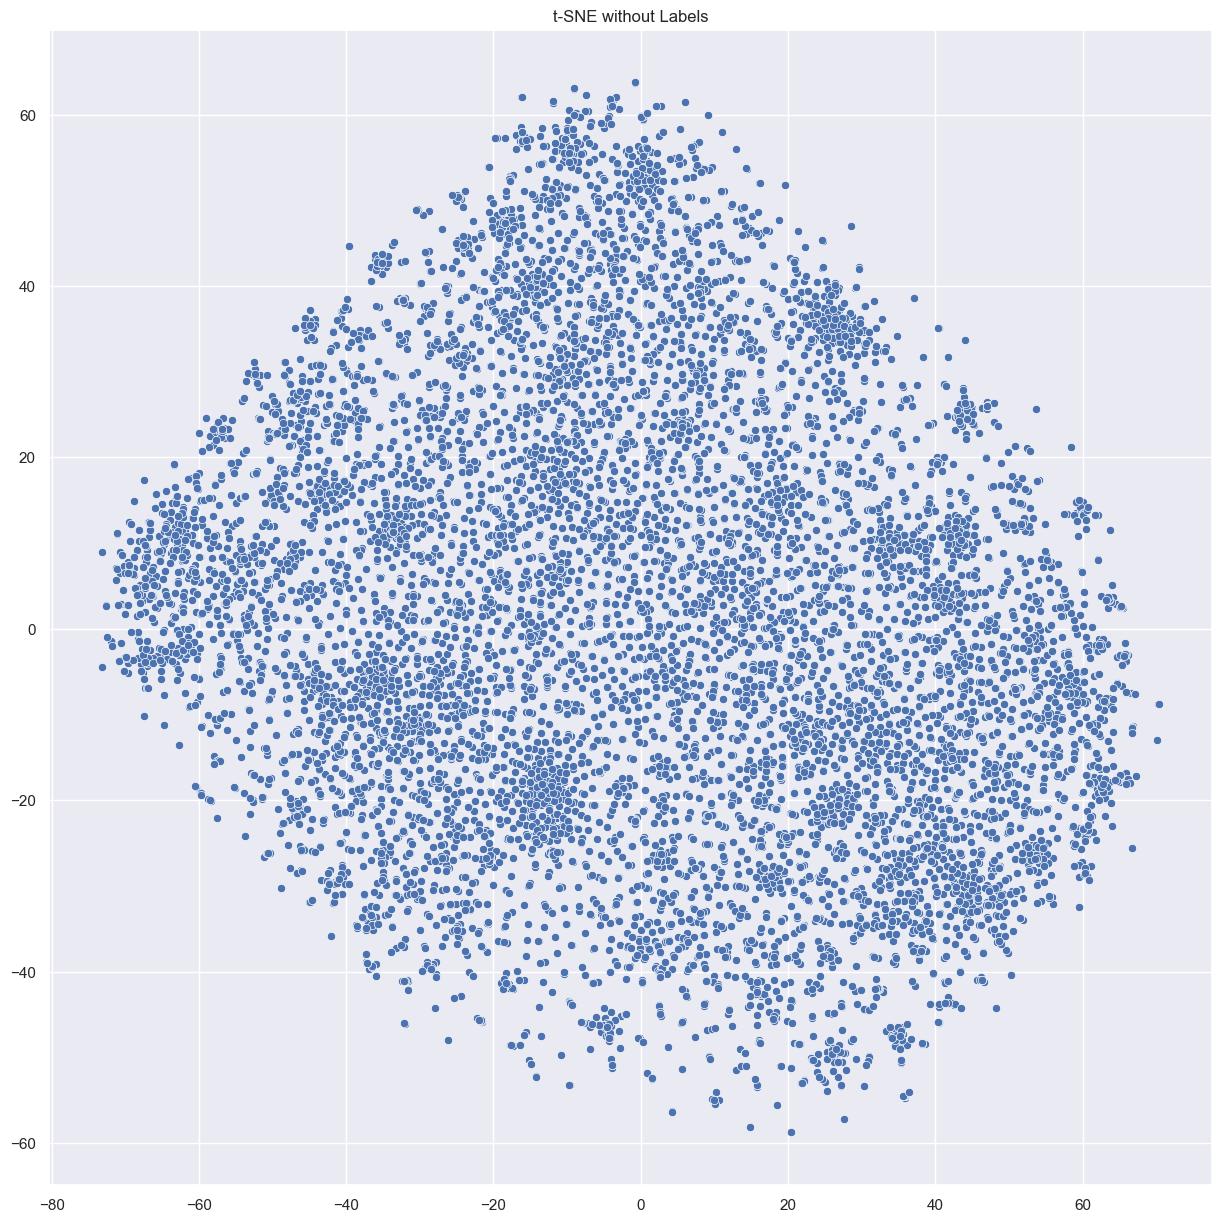

In [34]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-sne_arxvid.png")
plt.show()

/var/folders/hn/p77x1w5x5s725x1wyvhfn59h0000gn/T/ipykernel_7112/3256856644.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)


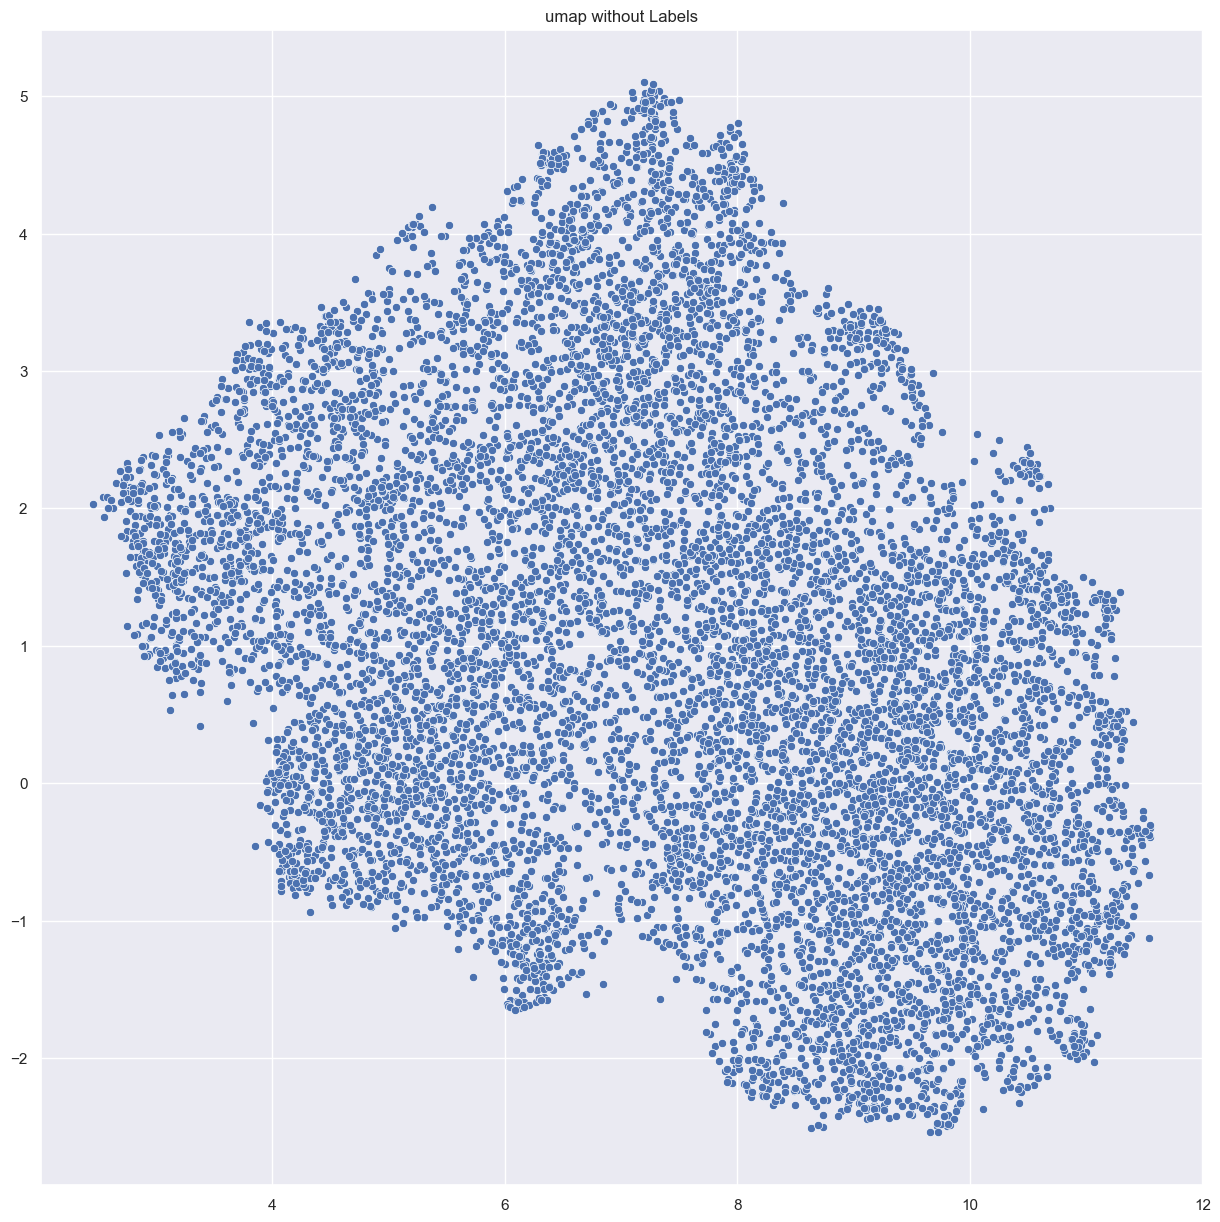

In [35]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)
plt.title('umap without Labels')
plt.savefig("umap_arxvid.png")
plt.show()

# Plot Clusters

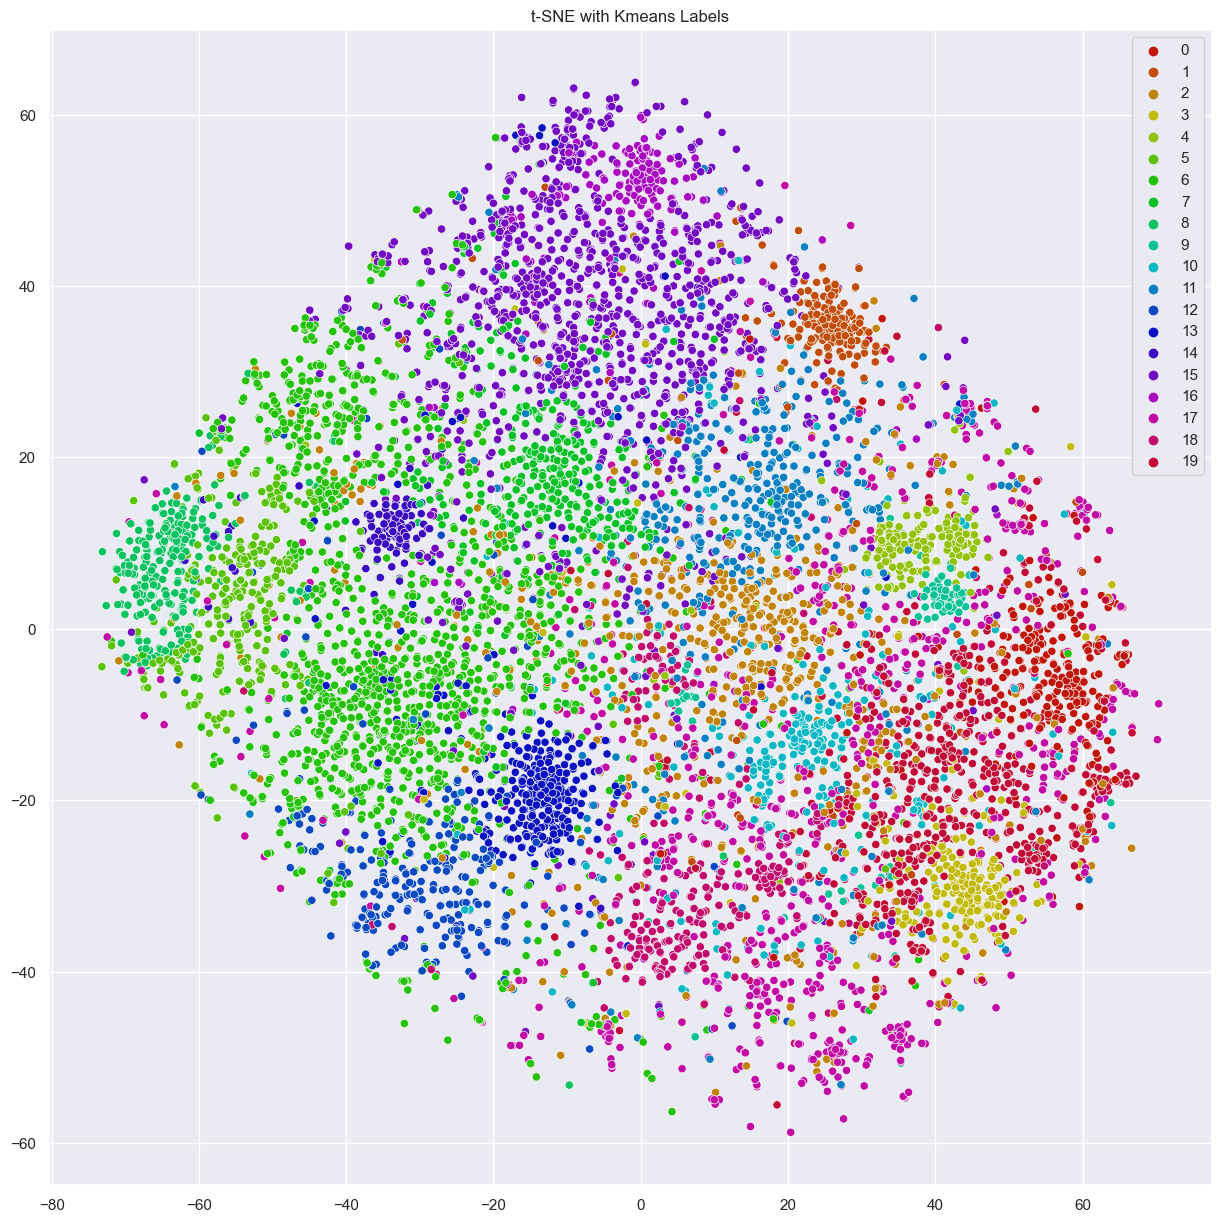

In [36]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("cluster_tsne.png")
plt.show()

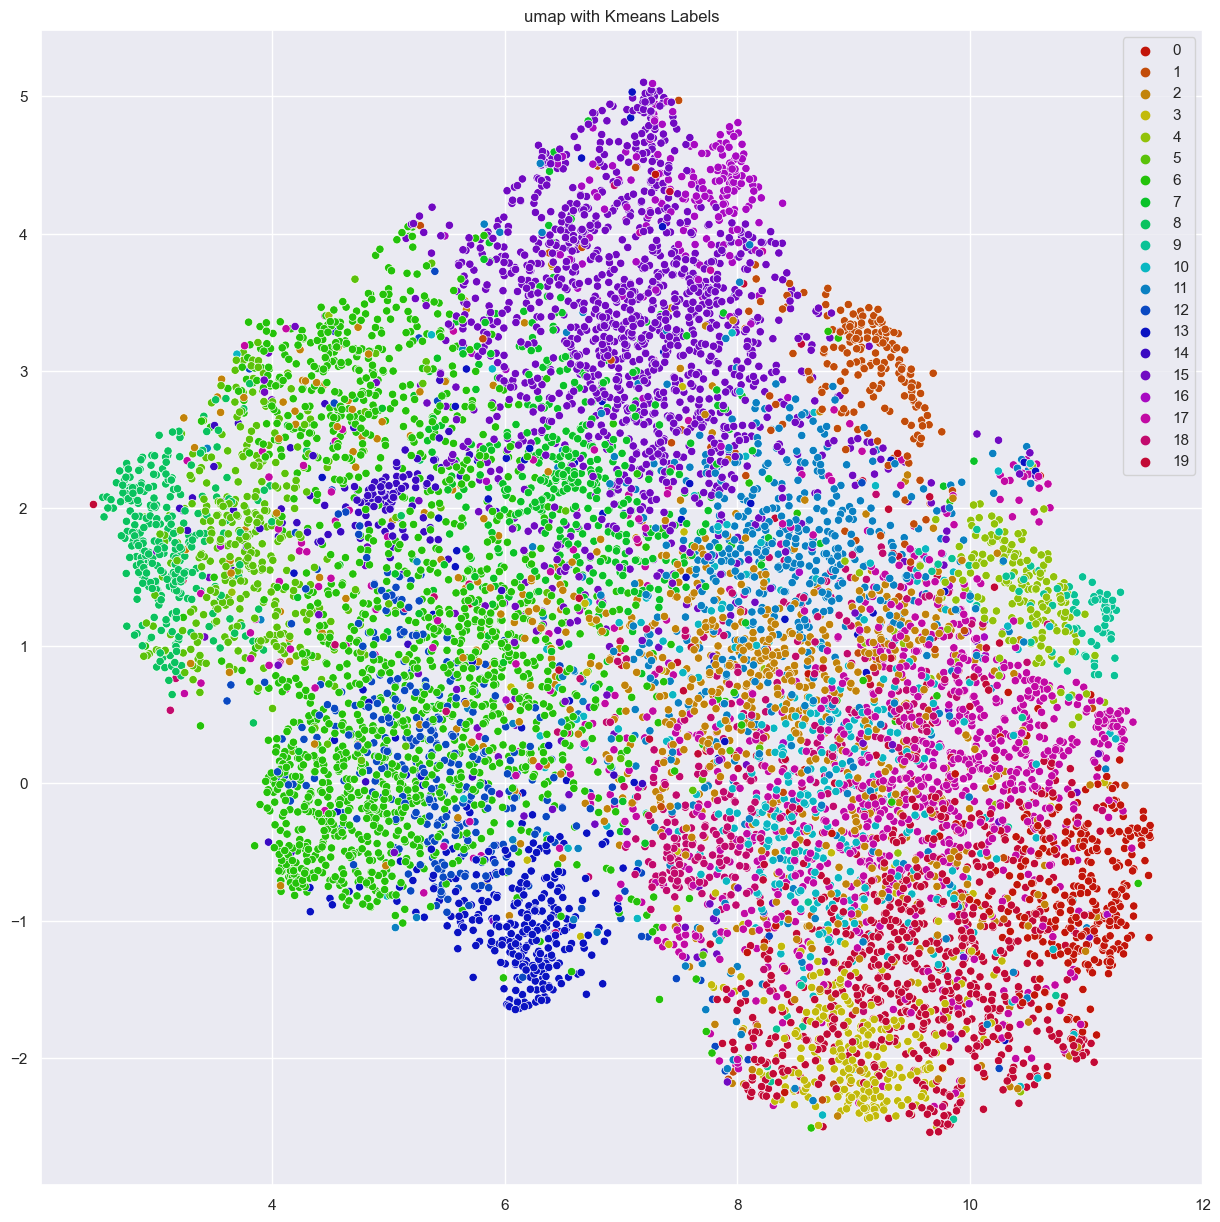

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('umap with Kmeans Labels')
plt.savefig("cluster_umap_kmeans_labels.png")
plt.show()

The labeled plot gives insights of how the papers are grouped.
It is difficult to say which dimension reduction performs better for this data. The performance would have to be evaluated in further steps.

The location of each paper on the plot was determined by umap / t-SNE while the labels (colors) was determined by k-means.
If we look at a particular parts of the plots where t-SNE and umap have grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster.

In other cases the labels (k-means) are more spread out on the plot (umap /t-SNE). This means that umap / t-SNE and k-means found differences in the higher dimensional data.

This could be because certain contents in the papers overlaping, so it's hard to clearly separate them. This effect can be observed in the formation of subclusters on the plot.

The algorithms may find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

# Plot interactive scatter plot bases on t-SNE

In [38]:
import plotly.express as px
fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()